In [37]:
import pandas as pd
import joblib
import numpy as np
from konlpy.tag import Okt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder

In [38]:
test = pd.read_csv('data/oid=008&date=20251218-Copy1.csv')
test

,날짜,제목,본문,링크
0,2025-12-18 23:05:00,"미국 11월 CPI, 전년 대비 2.7% 상승…전망치·전월치 모두 밑돌아",미국 11월 소비자물가지수(CPI)가 전년 대비 2.7% 상승했다고 18일(현지시간...,https://n.news.naver.com/mnews/article/008/000...
1,2025-12-18 23:01:00,"운동으로 뺐다던 입짧은햇님...""하루 약 3번"" '주사이모' 의혹에 발칵",먹방 유튜버 입짧은햇님(44·본명 김미경)이 박나래 '주사 이모'에게 다이어트약을 ...,https://n.news.naver.com/mnews/article/008/000...
2,2025-12-18 22:32:00,"연말 음주 귀갓길 비극...택시서 내리다 '콰당', 뒤차에 치여 숨졌다[영상]",송년 모임을 마치고 귀가하던 70대 남성이 택시에서 내린 후 달려오던 뒤차에 치여 ...,https://n.news.naver.com/mnews/article/008/000...
3,2025-12-18 22:11:00,"英 기준금리 4%→3.75%, 0.25%p 인하…""추가 완화는 신중히""",영국 중앙은행 영란은행(BOE)이 예상대로 기준금리 인하를 단행했다. 18일(현지...,https://n.news.naver.com/mnews/article/008/000...
4,2025-12-18 21:36:00,"제주 여행 갔다가 날벼락…20대 게하 직원, 만취 투숙객 성폭행",제주도 한 게스트하우스 20대 남성 직원이 여성 투숙객을 성폭행한 혐의로 징역 6년...,https://n.news.naver.com/mnews/article/008/000...
...,...,...,...,...
552,2025-12-18 04:02:00,2030년까지 'AI 팩토리' 500개 보급… 제조업 AI 전환 속도,산업통상부가 내년 최우선 국정과제로 '지역 중심 경제성장'을 선언했다. 지방에 파격...,https://n.news.naver.com/mnews/article/008/000...
553,2025-12-18 04:01:00,새 집 안 짓는 中… '건설 광풍시대' 종식,중국의 주택 신규착공이 판매되는 물량의 절반 가까운 비중으로 추락했다. 과거 금융위...,https://n.news.naver.com/mnews/article/008/000...
554,2025-12-18 04:00:00,남산 케이블카 '64년 독점' 깨질까...'명동→정상 5분' 곤돌라 운명은,명동역에서 남산 정상까지 5분 만에 갈 수 있는 '남산 곤돌라'를 설치할 수 있을지...,https://n.news.naver.com/mnews/article/008/000...
555,2025-12-18 02:05:00,[MT시평]과다 인건비의 손금부인 문제,최근 임원의 인건비와 관련한 조세분쟁이 증가하고 있다. 법인이 임원에게 직무집행의 ...,https://n.news.naver.com/mnews/article/008/000...


In [40]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
from sklearn.preprocessing import LabelEncoder

# 1. 저장된 경로 설정
model_path = "./my_kobert_model"

# 2. 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. 모델 및 토크나이저 불러오기
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# 4. 라벨 인코
le = LabelEncoder()
le.classes_ = np.load('classes.npy', allow_pickle=True)

print("모델 로드")

모델 로드


In [50]:
import pandas as pd
from tqdm.auto import tqdm

def predict_industry_to_df(df, text_column='본문', batch_size=32, threshold=0.7):
    model.eval()
    
    # 1. 텍스트 추출 및 전처리 (결측값 대비)
    texts = df[text_column].fillna("").astype(str).tolist()
    
    all_labels = []
    all_probs = []
    
    print(f"분류 시작: 총 {len(texts)}개의 기사를 분석합니다.")
    
    # 2. RTX 5080 최적화를 위한 배치 추론
    with torch.inference_mode():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i+batch_size]
            
            # 토크나이징 및 GPU 전송
            inputs = tokenizer(
                batch_texts, 
                return_tensors="pt", 
                truncation=True, 
                padding=True, 
                max_length=256
            ).to(device)
            
            # 모델 예측
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            max_probs, idxs = torch.max(probs, dim=1)
            
            # 결과 해석 및 임계값 적용
            for prob, idx in zip(max_probs.cpu().numpy(), idxs.cpu().numpy()):
                label_name = le.inverse_transform([idx])[0]
                
                # 확신도가 낮으면 '분류 불가' 처리 (필요에 따라 조정)
                if prob < threshold:
                    all_labels.append(f"분류 불가({prob:.2f})")
                else:
                    all_labels.append(label_name)
                all_probs.append(float(prob))
                
    # 3. 데이터프레임에 새로운 컬럼 추가
    df['산업'] = all_labels
    df['확신도'] = all_probs
    
    return df

# --- 실행 ---
# 데이터프레임에 적용
test = predict_industry_to_df(test)

# 결과 확인
print("\n 완료 --- 결과 ---")
print(test[['제목', '산업', '확신도']].head(10))

# 특정 산업(예: 건설)이 어떻게 분류되었는지 확인해보기
print("\n--- '건설'로 분류된 기사 샘플 ---")
print(test[test['산업'] == '건설'][['제목', '확신도']].head())
print("\n--- '자동차'로 분류된 기사 샘플 ---")
print(test[test['산업'] == '자동차'][['제목', '확신도']].head())
print("\n--- '헬스케어'로 분류된 기사 샘플 ---")
print(test[test['산업'] == '헬스케어'][['제목', '확신도']].head())

분류 시작: 총 557개의 기사를 분석합니다.


  0%|          | 0/18 [00:00<?, ?it/s]


 완료 --- 결과 ---
                                            제목    산업       확신도
0     미국 11월 CPI, 전년 대비 2.7% 상승…전망치·전월치 모두 밑돌아  해당없음  0.983721
1     운동으로 뺐다던 입짧은햇님..."하루 약 3번" '주사이모' 의혹에 발칵  해당없음  0.982589
2  연말 음주 귀갓길 비극...택시서 내리다 '콰당', 뒤차에 치여 숨졌다[영상]  해당없음  0.979167
3      英 기준금리 4%→3.75%, 0.25%p 인하…"추가 완화는 신중히"  해당없음  0.982312
4          제주 여행 갔다가 날벼락…20대 게하 직원, 만취 투숙객 성폭행  해당없음  0.981224
5        허위·조작정보 근절법, 與 주도 법사위 통과...22일 본회의 상정  해당없음  0.983250
6   구윤철 "한국 시장 매력 높일 정책 병행…환율 방어에 국민연금 동원 안 해"  해당없음  0.983424
7        미국 의회, 국방수권법서 '한국 조선사 투자 유치 검토' 조항 삭제  해당없음  0.949041
8           신안산선 공사 현장 사고로 1명 사망…고용부·국토부 조사 착수    건설  0.818010
9   "의사인 줄"...'불법 시술 인정' 키, 연예대상 MC 하차→가요대전 불참  해당없음  0.982865

--- '건설'로 분류된 기사 샘플 ---
                                             제목       확신도
8            신안산선 공사 현장 사고로 1명 사망…고용부·국토부 조사 착수  0.818010
56                잠실대교 남단 공사장서 크레인 전도…작업자 1명 매몰  0.746654
68                 여의도역 신안산선 공사장 '철근 낙하'…1명 심정지  0.773519
153                가덕도신공항건설공단-수자원공

### 산업별 기사 분류 현황 ###
해당없음           457
헬스케어            35
자동차             20
건설              17
분류 불가(0.70)      6
분류 불가(0.69)      3
분류 불가(0.60)      3
분류 불가(0.61)      2
분류 불가(0.59)      2
분류 불가(0.52)      2
분류 불가(0.63)      2
분류 불가(0.50)      1
분류 불가(0.54)      1
분류 불가(0.65)      1
분류 불가(0.68)      1
분류 불가(0.58)      1
분류 불가(0.57)      1
분류 불가(0.51)      1
분류 불가(0.64)      1
Name: 산업, dtype: int64
------------------------------
전체 기사 수: 557개


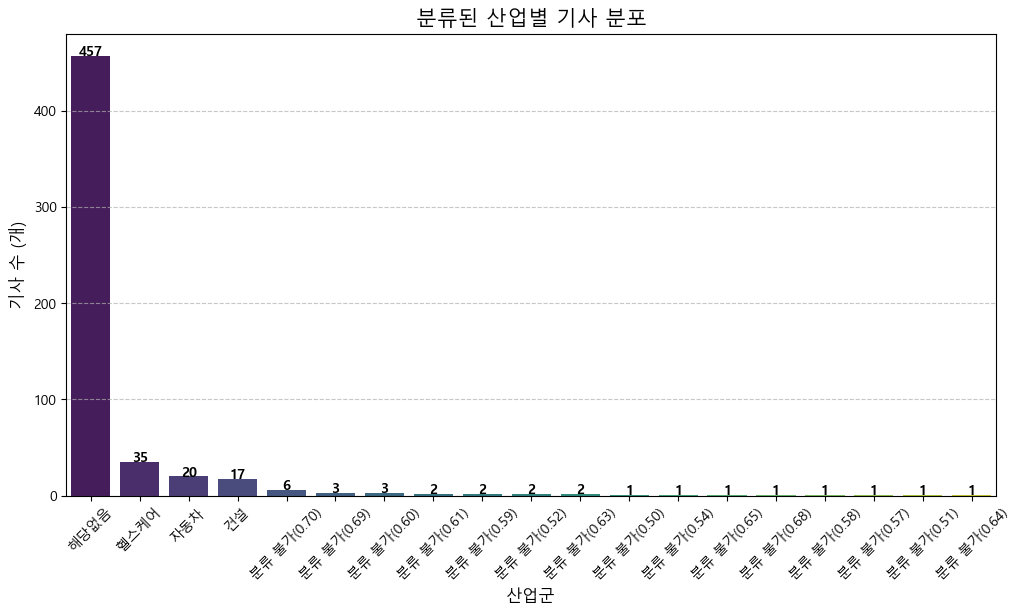

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (윈도우 환경)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 산업별 기사 개수 집계 (value_counts)
industry_counts = test['산업'].value_counts()

print("### 산업별 기사 분류 현황 ###")
print(industry_counts)
print("-" * 30)
print(f"전체 기사 수: {len(test)}개")

# 2. 시각화 (막대 그래프)
plt.figure(figsize=(12, 6))
sns.barplot(x=industry_counts.index, y=industry_counts.values, palette='viridis')

plt.title('분류된 산업별 기사 분포', fontsize=15)
plt.xlabel('산업군', fontsize=12)
plt.ylabel('기사 수 (개)', fontsize=12)

# 막대 위에 숫자 표시
for i, v in enumerate(industry_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [55]:
test[test['산업']=='헬스케어']

,날짜,제목,본문,링크,산업
22,2025-12-18 18:59:00,"오스코텍, ""1.5조 사노피 딜은 시작…5년 내 최소 3건 글로벌 기술이전""","""오스코텍에게 'ADEL-Y01' 기술이전은 터닝 포인트입니다. 이번 경사는 끝이 ...",https://n.news.naver.com/mnews/article/008/000...,헬스케어
31,2025-12-18 18:00:00,"넥셀, 美 'FDA 현대화법 3.0' 통과 호재 ""동물대체시험 시장 선점 가속""",[이 기사에 나온 스타트업에 대한 보다 다양한 기업정보는 유니콘팩토리 빅데이터 플랫...,https://n.news.naver.com/mnews/article/008/000...,헬스케어
48,2025-12-18 17:37:00,"한의사들 ""정은경 장관, 망언 사죄하고 난임 한의치료 지원해야""",한의약 난임치료와 관련해 '의사 출신' 정은경 보건복지부 장관의 발언을 규탄하는 한...,https://n.news.naver.com/mnews/article/008/000...,헬스케어
49,2025-12-18 17:36:00,"셀트리온 ""임시주총 소집 청구, 법적 요건 미충족…서류 보완 시 진행할 것""",셀트리온이 최근 셀트리온 소액주주 비상대책 위원회(이하 비대위)가 제기한 임시주주총...,https://n.news.naver.com/mnews/article/008/000...,헬스케어
57,2025-12-18 17:17:00,한국인 암 환자 느는데 사망률은 40% 급감...이런 이유 있었다,국내 암환자수와 암사망자수가 늘어나고 있지만 2001년 인구 10만명당 246.2명...,https://n.news.naver.com/mnews/article/008/000...,헬스케어
59,2025-12-18 17:16:00,"리비오젠, '반려동물 피부 검체 기반 질환 예측 기술' 국제 특허 출원",리비오젠(대표 이준형)이 피부 검체를 기반으로 반려동물의 질환을 예측하는 기술에 대...,https://n.news.naver.com/mnews/article/008/000...,헬스케어
64,2025-12-18 17:13:00,"씨티셀즈, 디자인바이제이와 업무협약 체결","CTC(순환종양세포, Circulating Tumor Cell) 진단·분석 전문기업...",https://n.news.naver.com/mnews/article/008/000...,헬스케어
80,2025-12-18 16:57:00,"에버파인, '중국창춘국제의약건강산업박람회'서 공급협상 성과...KOTRA 지원",(주)에버파인(everpine) 이 12월 7일부터 9일까지 중국 지린성 창춘에서 ...,https://n.news.naver.com/mnews/article/008/000...,헬스케어
126,2025-12-18 16:14:00,"진원생명과학, 흡인 기반 DNA 백신 접종 기술 연구 국제학술지 게재",진원생명과학이 개발한 흡인(Suction) 기반 피내 DNA(유전자) 백신 접종 기...,https://n.news.naver.com/mnews/article/008/000...,헬스케어
127,2025-12-18 16:14:00,"에스티큐브, 1월 ASCO GI에서 대장암 1b상 바이오마커 분석 결과 발표",에스티큐브는 소화기암 분야 세계 최대 규모 학회인 'ASCO GI'(미국임상종양학회...,https://n.news.naver.com/mnews/article/008/000...,헬스케어


In [54]:
test[test['산업']=='자동차']

,날짜,제목,본문,링크,산업
61,2025-12-18 17:14:00,수요둔화 우려에 이차전지株 '풀썩'…LG엔솔 8%대 '급락',LG에너지솔루션이 9조6000억원 규모 배터리 공급 계약 해지 소식에 급락했다. 이...,https://n.news.naver.com/mnews/article/008/000...,자동차
111,2025-12-18 16:33:00,"새솔테크, 'CES 2026'서 도로 취약층 보호 'V2X 보안 기술' 공개",자율주행 및 커넥티드카 보안 솔루션 기업 새솔테크(대표 한준혁)가 2026년 1월 ...,https://n.news.naver.com/mnews/article/008/000...,자동차
138,2025-12-18 15:57:00,아산 스마트시티 무인순찰로봇 구축.. 팀그릿·호서대 협력 본격화,아산시 강소형 스마트시티 조성사업의 핵심 과제 중 하나인 무인순찰로봇 구축 사업이 ...,https://n.news.naver.com/mnews/article/008/000...,자동차
155,2025-12-18 15:41:00,"""탈출 코앞인데"" 2차전지 개미들 또 곡소리...공매도 잔고 '쑥'",미국 완성차 제조사 포드와 LG에너지솔루션 사이 대형 공급계약이 무산되며 2차전지 ...,https://n.news.naver.com/mnews/article/008/000...,자동차
201,2025-12-18 14:50:00,학생 안전 우선…경기도 '학교 전기차 충전시설 제외' 조례 가결,경기도 내 학교가 전기차 충전시설 설치 의무 대상에서 제외될 가능성이 더 커졌다. ...,https://n.news.naver.com/mnews/article/008/000...,자동차
333,2025-12-18 11:25:00,"LG엔솔, 9.6조 배터리 계약 해지에 40만원선 붕괴…이차전지株 '휘청'",LG에너지솔루션이 9조6000억원 규모 배터리 공급 계약 해지 소식에 급락했다. 이...,https://n.news.naver.com/mnews/article/008/000...,자동차
335,2025-12-18 11:23:00,"현대차그룹, 기술 인재 전면 배치…미래 모빌리티 전환 가속",현대자동차그룹이 소프트웨어 중심 모빌리티 기업으로의 전환을 주도할 핵심 인사로 만프...,https://n.news.naver.com/mnews/article/008/000...,자동차
365,2025-12-18 10:57:00,[프로필]이보룡 현대제철 대표이사 사장,현대자동차그룹은 18일 2025년 임원 인사를 통해 이보룡 현대제철 생산본부장 부사...,https://n.news.naver.com/mnews/article/008/000...,자동차
367,2025-12-18 10:54:00,[프로필]정준철 현대차·기아 제조부문장 사장,현대자동차그룹이 하드웨어 영역에서의 제조 경쟁력을 한 층 강화하고 소프트웨어 중심 ...,https://n.news.naver.com/mnews/article/008/000...,자동차
382,2025-12-18 10:44:00,[프로필]만프레드 하러 현대차·기아 R&D본부장 사장,현대자동차그룹이 만프레드 하러 현대차·기아 차량개발담당 부사장을 R&D본부장 사장으...,https://n.news.naver.com/mnews/article/008/000...,자동차


In [57]:
test[test['산업']=='건설']

,날짜,제목,본문,링크,산업
8,2025-12-18 21:04:00,신안산선 공사 현장 사고로 1명 사망…고용부·국토부 조사 착수,서울 여의도 신안산선 지하 공사 현장에서 사고로 다수의 부상자가 발생하고 50대 작...,https://n.news.naver.com/mnews/article/008/000...,건설
56,2025-12-18 17:20:00,잠실대교 남단 공사장서 크레인 전도…작업자 1명 매몰,서울 송파구 잠실대교 남단의 한 공사 현장에서 크레인이 전도되는 사고가 발생해 작업...,https://n.news.naver.com/mnews/article/008/000...,건설
68,2025-12-18 17:11:00,여의도역 신안산선 공사장 '철근 낙하'…1명 심정지,서울 영등포구 여의도 신안산선 공사현장에서 철근 구조물이 낙하하는 사고가 발상했다....,https://n.news.naver.com/mnews/article/008/000...,건설
153,2025-12-18 15:44:00,가덕도신공항건설공단-수자원공사 신공항 건설 등 협력,가덕도신공항건설공단과 한국수자원공사가 18일 가덕도신공항 건설사업의 성공적 추진과 ...,https://n.news.naver.com/mnews/article/008/000...,건설
160,2025-12-18 15:35:00,"""바닷물 10만t 공업용수로"" GS건설, 국내 최대 '해수담수화 시설' 준공",GS건설이 하루 10만톤의 해수를 공장 운영에 필요한 용수로 바꿀 수 있는 시설을 ...,https://n.news.naver.com/mnews/article/008/000...,건설
178,2025-12-18 15:12:00,"김성은 덕진종합건설 대표, 대한주택건설협회 제14대 회장 선출",김성은 덕진종합건설 대표이사가 대한주택건설협회 제14대 중앙회장으로 선출됐다. 주...,https://n.news.naver.com/mnews/article/008/000...,건설
198,2025-12-18 14:55:00,서울 여의도역 신안산선 공사장서 철근 무너져…1명 심정지,서울 영등포구 여의도 신안산선 공사 현장에서 작업자 3명이 다치는 사고가 발생했다....,https://n.news.naver.com/mnews/article/008/000...,건설
227,2025-12-18 14:34:00,여의도역 신안산선 공사 현장서 철근 추락…최소 2명 부상,서울 여의도 신안산선 공사 현장에서 철근이 추락하는 사고가 발생했다. 18일 오후...,https://n.news.naver.com/mnews/article/008/000...,건설
256,2025-12-18 14:02:00,"조달청, 건설현장 고위험 작업 특별점검","조달청은 18일 부산광역시 기장군에 위치한 '부산촬영소 건립공사' 현장을 방문, 중...",https://n.news.naver.com/mnews/article/008/000...,건설
258,2025-12-18 14:01:00,"윤호중 행안장관, 초고층건물 화재 대비·제설 대응체계 점검",행정안전부는 윤호중 장관이 18일 본격적인 겨울철을 맞아 서울 지역의 제설상황과 초...,https://n.news.naver.com/mnews/article/008/000...,건설


In [58]:
test[test['산업']=='해당없음']

,날짜,제목,본문,링크,산업
0,2025-12-18 23:05:00,"미국 11월 CPI, 전년 대비 2.7% 상승…전망치·전월치 모두 밑돌아",미국 11월 소비자물가지수(CPI)가 전년 대비 2.7% 상승했다고 18일(현지시간...,https://n.news.naver.com/mnews/article/008/000...,해당없음
1,2025-12-18 23:01:00,"운동으로 뺐다던 입짧은햇님...""하루 약 3번"" '주사이모' 의혹에 발칵",먹방 유튜버 입짧은햇님(44·본명 김미경)이 박나래 '주사 이모'에게 다이어트약을 ...,https://n.news.naver.com/mnews/article/008/000...,해당없음
2,2025-12-18 22:32:00,"연말 음주 귀갓길 비극...택시서 내리다 '콰당', 뒤차에 치여 숨졌다[영상]",송년 모임을 마치고 귀가하던 70대 남성이 택시에서 내린 후 달려오던 뒤차에 치여 ...,https://n.news.naver.com/mnews/article/008/000...,해당없음
3,2025-12-18 22:11:00,"英 기준금리 4%→3.75%, 0.25%p 인하…""추가 완화는 신중히""",영국 중앙은행 영란은행(BOE)이 예상대로 기준금리 인하를 단행했다. 18일(현지...,https://n.news.naver.com/mnews/article/008/000...,해당없음
4,2025-12-18 21:36:00,"제주 여행 갔다가 날벼락…20대 게하 직원, 만취 투숙객 성폭행",제주도 한 게스트하우스 20대 남성 직원이 여성 투숙객을 성폭행한 혐의로 징역 6년...,https://n.news.naver.com/mnews/article/008/000...,해당없음
...,...,...,...,...,...
551,2025-12-18 04:04:00,2030년 재생에너지 100GW 보급… 기업엔 세금감면 혜택,정부가 2030년까지 재생에너지 100GW(기가와트) 시대를 연다. 주민이 돈을 버...,https://n.news.naver.com/mnews/article/008/000...,해당없음
552,2025-12-18 04:02:00,2030년까지 'AI 팩토리' 500개 보급… 제조업 AI 전환 속도,산업통상부가 내년 최우선 국정과제로 '지역 중심 경제성장'을 선언했다. 지방에 파격...,https://n.news.naver.com/mnews/article/008/000...,해당없음
554,2025-12-18 04:00:00,남산 케이블카 '64년 독점' 깨질까...'명동→정상 5분' 곤돌라 운명은,명동역에서 남산 정상까지 5분 만에 갈 수 있는 '남산 곤돌라'를 설치할 수 있을지...,https://n.news.naver.com/mnews/article/008/000...,해당없음
555,2025-12-18 02:05:00,[MT시평]과다 인건비의 손금부인 문제,최근 임원의 인건비와 관련한 조세분쟁이 증가하고 있다. 법인이 임원에게 직무집행의 ...,https://n.news.naver.com/mnews/article/008/000...,해당없음
